In [1]:
#examine differentiable histogram loss
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
f = torch.nn.ReLU()

In [3]:
def diff_hist(s,N,delta,R):
    #R: number of bins
    #delta: bin width
    #s: sample set (N samples in total)
    #no parallel run
    s = torch.reshape(s,(N,1))
    r = torch.linspace(1,R-2,R-2).repeat(N,1)
    T_r = -1 + r*delta
    T_rm1 = -1 + r*delta - delta
    T_rp1 = -1 + r*delta + delta
    return f(torch.sum(f(s - T_rm1) - 2.0*f(s - T_r) + f(s - T_rp1), axis = 0)/(N*delta))

In [4]:
def diff_hist_p(s,N,p,delta,R):
    #R: number of bins
    #delta: bin width
    #s: sample set (p runs, N samples each run)
    #p: parallel runs
    s = torch.reshape(s,(p,N,1))
    r = torch.linspace(1,R-2,R-2).repeat(p,N,1)
    T_r = -1 + r*delta
    T_rm1 = -1 + r*delta - delta
    T_rp1 = -1 + r*delta + delta
    return f(torch.sum(f(s-T_rm1) - 2.0*f(s-T_r) + f(s - T_rp1), axis = 1)/(N*delta))

tensor(1.0000)


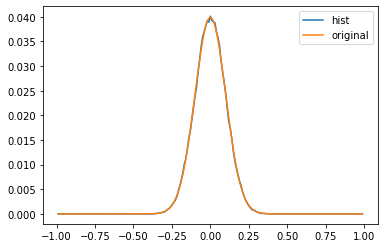

In [5]:
#test on synthesized data
s = torch.randn(100000)*0.1
N = 100000
delta = 0.01
R = 201
t = np.arange(1,200)*0.01-1
plt.plot(t,diff_hist(s,N,delta,R).numpy())
plt.plot(t,10/2**0.5/np.pi**0.5*np.exp(-50*t**2)*0.01)
plt.legend(['hist','original'])
print(torch.sum(diff_hist(s,N,delta,R)))

tensor(1.0000)
loss
tensor(0.1867, dtype=torch.float64)


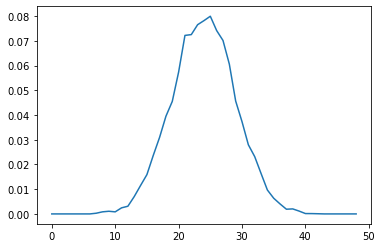

In [6]:
p = 20
N = 5000
R = 51
delta = 0.04
s = torch.randn(p,N)*0.2
hist_p = diff_hist_p(s,N,p,delta,R)
plt.plot(hist_p.numpy()[4])
print(torch.sum(hist_p[4]))

t = np.arange(1,R-1)*delta-1
target_hist = torch.tensor(1/2**0.5/np.pi**0.5/0.2*np.exp(-1/2/(0.2)**2*t**2)).repeat(p,1)
target_hist = target_hist/np.sum(1/2**0.5/np.pi**0.5/0.2*np.exp(-1/2/(0.2)**2*t**2))

print('loss')
print(torch.sum(torch.sum(target_hist*torch.log((target_hist + 1e-20)/(hist_p + 1e-20)),axis = 1)))

In [7]:
#define global constant
p = 20 #parallel runs
N = int(5000) #steps per run/20
R = 51 #no. bins + 1
delta_t = 1e-3 #discretization of time
tau = 0.02 #membrane potential
sigma_target = 0.4 #desired std
hist_min = -2.0 #histogram range
hist_max = 2.0

In [8]:
def diff_hist_p1(s,N,p,R,hist_min,hist_max):
    #R: number of bins
    #delta: bin width
    #s: sample set (p runs, N samples each run)
    #p: parallel runs
    delta = (hist_max - hist_min)/(R-1)
    s = torch.reshape(s,(p,N,1))
    r = torch.linspace(1,R-2,R-2).repeat(p,N,1)
    T_r = hist_min + r*delta
    T_rm1 = hist_min + r*delta - delta
    T_rp1 = hist_min + r*delta + delta
    return f(torch.sum(f(s-T_rm1) - 2.0*f(s-T_r) + f(s - T_rp1), axis = 1)/(N*delta))

In [9]:
class network1():
    def forward(c,w):
        r = torch.randn(4,p)
        s = torch.zeros(p,N)
        for i in range(int(20*N)):
            r = r + delta_t * (-r/tau + w@r) + (2/tau)**0.5*delta_t**0.5*c@torch.randn(4,p)
            if i%20 == 0:
                s[:,i//20] = r[2,:]
        return s
    
    def kl_loss(s):
        delta = (hist_max - hist_min)/(R-1)
        t = np.arange(1,R-1)*(hist_max - hist_min)/(R-1) - hist_max
        target_hist = torch.tensor(1/2**0.5/np.pi**0.5/sigma_target*np.exp(-1/2/(sigma_target)**2*t**2)).repeat(p,1)
        target_hist = target_hist/np.sum(1/2**0.5/np.pi**0.5/sigma_target*np.exp(-1/2/(sigma_target)**2*t**2))
        return torch.sum(torch.sum(target_hist*torch.log((target_hist + 1e-20)/(diff_hist_p1(s,N,p,R,hist_min,hist_max) + 1e-20)),axis = 1))

In [10]:
network1.kl_loss(torch.randn(p,N)*0.34)

tensor(1.3830, dtype=torch.float64)

In [13]:
max_eig = True
while max_eig:
    w = torch.autograd.Variable(torch.randn(4,4),requires_grad = True).float()
    if torch.max(torch.real((torch.linalg.eig(w.detach())[0])))<1:
        max_eig = False
        
m = torch.nn.Tanh()

c = torch.autograd.Variable(2*torch.randn(4,4),requires_grad = True).float()

optimizer = torch.optim.Adam([w,c], 0.2)

In [19]:
import sys
loss_list = []
L = 0

optimizer = torch.optim.Adam([w,c], 0.2)

for v in range(10):
    optimizer.zero_grad()
    samples = network1.forward(c,w)
    L = network1.kl_loss(samples)
    
    L1 = L.detach().numpy().copy()
    print(L1)
    loss_list.append(L1)
    
    if np.isnan(L1) == True:
        print('error')
        sys.exit(0)
        
    L.backward()
    optimizer.step()

1.2276196119677611
7.154961355836288
0.9162001989342841
3.1728082822164883
4.3616971971065714
4.555237792693317
4.24572486465134
3.4621570348612924
2.174406678334467
0.8490531275018988


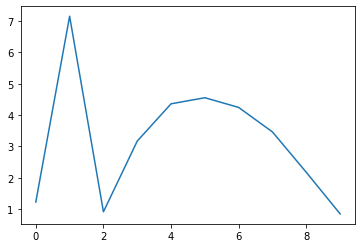

In [20]:
plt.plot(loss_list)

In [21]:
def test(c,w):
    r = torch.randn(4,1)
    resp = torch.zeros(20*N)
    for i in range(int(20*N)):
        r = r + delta_t * (-r/tau + w@r) + (2/tau)**0.5*delta_t**0.5*c@torch.randn(4,1)
        resp[i] = r[2]
    return resp.detach().numpy()

In [22]:
resp = test(c,w)

In [23]:
print(np.mean(resp))
print(np.std(resp))

-0.00056015945
0.4076992
